In this notebook, we'll visualize the uncertainty of a regression analysis by using a visualization technique called **hypothetical outcome plots**

The adopted regression method is the **Gaussian Process** approach, which is delivered by using the GP implementation from `Scikit-Learn`

##Hypothetical Outcome Plots
Hypothetical outcome plots (HOP) is an effective approach to communicate **data uncertainty**

>This method visualizes uncertainty through animations by cycling through a number of different plots, each of which represents one possible outcome drawn from the outcome distribution


In [1]:
# Import libraries and set plots to be embedded inline
import numpy as np
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from pylab import rcParams
rcParams['figure.figsize'] = 14,8

%matplotlib inline
np.set_printoptions(precision=2, suppress=True)

import warnings
warnings.filterwarnings('ignore')

### 1. Generate training data
We create some *noisy* training data. First of all, we generate clean data using the following test function:

\begin{equation}
f(x) = (6x-2)^2 sin(12x-4), \; x \in [0, 1]
\end{equation}

Later, we'll *pollute* the clean data by adding random noise

In [2]:
# Sample locations
X_train = np.array([[0,0.04,0.06,0.07,0.1,0.12,0.15,\
                     0.18,0.2,0.24,0.31,0.35,0.38,0.4,0.44,\
                     0.5,0.52,0.55,0.62,0.67,0.73,0.8,0.9,0.96,1]]).T
# Generate clean data
y_clean = (X_train*6-2)**2*np.sin(X_train*12-4)

# Generate noisy data
noise_std = 1
np.random.seed(42)
noise = np.random.normal(
    loc=0.0, 
    scale=noise_std, 
    size=(X_train.shape[0],1)
)

y_train = y_clean + noise

A visualization of the noisy training set

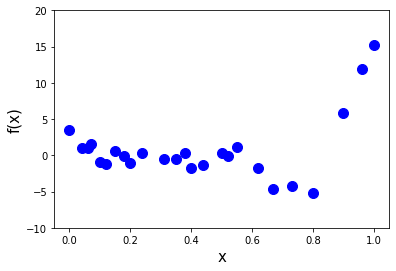

In [3]:
fig, ax = plt.subplots()
ax.plot(
    X_train,
    y_train,
    'bo',
    markerfacecolor='b',
    markersize=10,
    label='Training Data'
)

ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
plt.savefig('Regression_training_data')

### 2. GP model training and predicting

In this step, we train a GP model based on the generated training dataset and display its prediction results

In [4]:
# Train Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(
    kernel=kernel, 
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=30, 
    alpha=0.4, 
    normalize_y=True
)

model.fit(X_train, y_train)

# GP prediction
X_test = np.arange(0,1.01,0.01)
y_pred, pred_cov = model.predict(X_test.reshape((-1, 1)), return_cov=True)
y_pred = np.ravel(y_pred)

# Prediction standard deviation
pred_std = np.sqrt(np.diag(pred_cov))

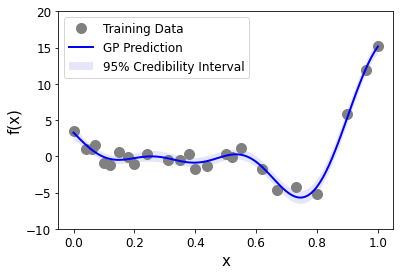

In [5]:
fig, ax = plt.subplots()
ax.plot(
    X_train,
    y_train,
    'o',
    color=(0.5,0.5,0.5),
    markerfacecolor=(0.5,0.5,0.5),
    markersize=10,label='Training Data'
)

ax.plot(
    X_test,
    y_pred,
    'b-',
    linewidth=2,
    label='GP Prediction'
)

ax.fill_between(
    X_test, 
    y_pred-1.96*pred_std, 
    y_pred+1.96*pred_std,
    facecolor='lavender',
    label='95% Credibility Interval'
)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left", prop={'size': 12})
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
plt.savefig('Regression_confidence_band')

In the above figure, a credibility interval is shown to display the uncertainty of the predictions of the trained GP model. This interval is calculated as $[\mu(x)-1.96\sigma(x), \mu(x)+1.96\sigma(x)]$, where $\mu(x)$ is the prediction mean and $\sigma(x)$ is the prediction standard deviation, at location $x$

Although this is a popular way to present model prediction uncertainty in academic research, for a broad audience, this static uncertainty visualization can be misleading:

1. people tend to perceive the credibility interval as the maximum/minimum bounds of the model prediction. In fact, those intervals merely indicate there is a high chance (95 out of 100, to be exact) that the true predictions will fall into the band. This does not rule out the possibility of observing a function value outside the band

2. the **correlation** between predictions at different $x$ locations is not directly conveyed in the credibility interval. As a result, people may think that the displayed credibility band is a result of simply moving the regression curve up and down. However, as we'll see shortly, the possible regression curves drawn from the GP posterior distribution could be quite different from the nominal one

### 3. Hypothetical outcome plots

In this step, we will create an animation to cycle through a number of random draws of possible GP regression curves. 

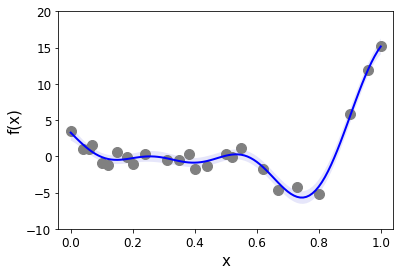

In [6]:
# Generate realizations of GP prediction
sample_num = 10
realizations = np.random.multivariate_normal(mean=y_pred, cov=pred_cov, size=sample_num)

fig, ax = plt.subplots()
ax.set(xlim=(-0.04, 1.04), ylim=(-10, 20))
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)

# Non-changing part
ax.plot(
    X_train,
    y_train,
    'o',
    color=(0.5,0.5,0.5),
    markerfacecolor=(0.5,0.5,0.5),
    markersize=10,
    label='Training Data'
)

ax.plot(
    X_test, 
    y_pred, 
    'b-', 
    linewidth=2, 
    label='GP Prediction'
)

ax.fill_between(
    X_test, 
    y_pred-1.96*pred_std, 
    y_pred+1.96*pred_std,
    facecolor='lavender',
    label='95% Credibility Interval'
)

ax.tick_params(axis='both', which='major', labelsize=12)

# Changing part
line, = ax.plot([], [], lw=2, label='Hypothetical Outcomes')


def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = X_test
    y = realizations[i-1,:]
    line.set_data(x,y)
    ax.legend(loc="upper left", prop={'size': 12})
    return line,

anim = animation.FuncAnimation(
    fig, 
    animate, 
    init_func=init,
    frames=sample_num, 
    interval=1000, 
    blit=True
)

#anim.save('Regression_animation.gif', writer='imagemagick')

The above animation allows the audiences to experience the GP prediction uncertainty first-hand. Instead of showing the confusing credibility band, HOP illustrate vividly the alternative regression curves supported by the given training data 

In [7]:
# Show in animation
HTML(anim.to_html5_video())